In [1]:
!pip install eo-learn-core==0.8.0
!pip install eo-learn-io==0.8.0

ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## tempcnn-example-sentinel2
multivariate sits classification with temporal convolutional networks
example with Sentinel-2 data

## extract-images (now eolearn, later aws)
## pre-processing (mask clouds and interpolate)
## get reference data
## load pre-processed data
## time series visualization
## build tempcnn and fit
## predict map



## pre-processing (mask clouds and interpolate)

In [2]:
# # load reference data
# import urllib
# lclu_slovenia = 'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/maps/si_lulc_reference.tiff'
# urllib.request.urlretrieve(lclu_slovenia, 'labels.tif')
# with rasterio.open('labels.tif') as src:
#   class_labels = src.read()
# class_labels.shape

In [3]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
import urllib
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
# import rasterio

def preprocessing(images, masks):
    """
    Pre-processing of image time series: 1. Masking of clouds, 2. Temporal resampling through linear interpolation.
    """
    ##### DUMMY: load pre-extracted eolearn data #####
    from eolearn.core import EOPatch, FeatureType
    from eolearn.io import ExportToTiff
    # load image data
    patch_name = 'eopatch_id_102_col_7_row_9'
    eo_slovenia = [
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/data/BANDS.npy.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/mask/IS_VALID.npy.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/mask_timeless/LULC.npy.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/bbox.pkl.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/meta_info.pkl.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/timestamp.pkl.gz'
    ]
    for fp in eo_slovenia:
        out_path = Path('.').resolve() / '/'.join(fp.split('/')[3:])
        if out_path.is_dir():
            out_path.mkdir(parents=True, exist_ok=True)
        else:
            out_path.parent.mkdir(parents=True, exist_ok=True)
        if not out_path.exists():
            urllib.request.urlretrieve(fp, out_path)[0]
      
    eo_path = str(Path('.').resolve() / fp.split('/')[3] / patch_name)
    print(eo_path)

    patch = EOPatch.load(eo_path)
    patch.data['BANDS'] = (patch.data['BANDS']*255).astype('uint8')
    print(np.bincount(patch.mask_timeless['LULC'].flatten()))

    input_list = []
    for i, band_name in enumerate(['B02', 'B03', 'B04', 'B08', 'B11', 'B12']):
        feature = (FeatureType.DATA, 'BANDS')
        out_dir = 'gdrive/MyDrive'
        export_task = ExportToTiff(feature, folder=out_dir, band_indices=[i], date_indices=[d for d in range(72)],
                                  compress='lzw')
        fn = f'{band_name}.tif'
        export_task.execute(patch, filename=fn)
        input_list.append(str(Path(out_dir).resolve()  / fn))
    ##### END of DUMMY: load pre-extracted eolearn data #####

    return input_list

input_list = preprocessing(images=None, masks=None)
print(input_list)

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


/content/eopatches_slovenia_2019/eopatch_id_102_col_7_row_9
[  2340  10873 116072  92298  19960     13      0      0   8441      3]
['/content/gdrive/MyDrive/B02.tif', '/content/gdrive/MyDrive/B03.tif', '/content/gdrive/MyDrive/B04.tif', '/content/gdrive/MyDrive/B08.tif', '/content/gdrive/MyDrive/B11.tif', '/content/gdrive/MyDrive/B12.tif']


## get reference data

In [43]:
def get_reference_data(filepath, bbox):
    # # load reference data
    # import urllib
    # filepath = 'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/maps/si_lulc_reference.tiff'
    # urllib.request.urlretrieve(filepath, 'labels.tif')
    # with rasterio.open('labels.tif') as src:
    #   class_labels = src.read()
    # class_labels.shape
    ##### DUMMY: load from eolearn patch #####
    from eolearn.core import EOPatch, FeatureType
    from eolearn.io import ExportToTiff
    # load image data
    patch_name = 'eopatch_id_102_col_7_row_9'
    eo_slovenia = [
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/mask_timeless/LULC.npy.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/bbox.pkl.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/meta_info.pkl.gz',
    f'http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/eopatches_slovenia_2019/{patch_name}/timestamp.pkl.gz'
    ]
    for fp in eo_slovenia:
        out_path = Path('.').resolve() / '/'.join(fp.split('/')[3:])
        if out_path.is_dir():
            out_path.mkdir(parents=True, exist_ok=True)
        else:
            out_path.parent.mkdir(parents=True, exist_ok=True)
        if not out_path.exists():
            urllib.request.urlretrieve(fp, out_path)[0]
      
    eo_path = str(Path('.').resolve() / fp.split('/')[3] / patch_name)
    print(eo_path)
    patch = EOPatch.load(eo_path)

    out_dir = 'gdrive/MyDrive'
    feature_name = 'LULC'
    feature = (FeatureType.MASK_TIMELESS, feature_name)
    export_task = ExportToTiff(feature, folder=out_dir, compress='lzw')
    fn = 'labels.tif'
    export_task.execute(patch, filename=fn)
    labels_path = (Path(out_dir).resolve()  / fn)
    print(labels_path)
    import rasterio
    with rasterio.open(labels_path) as src:
        class_labels = src.read().squeeze()
    ##### END DUMMY: load from eolearn patch #####
    
    return class_labels

class_labels = get_reference_data(filepath=None, bbox=None)[75:175, -150:-50]
class_labels.shape

/content/eopatches_slovenia_2019/eopatch_id_102_col_7_row_9
/content/gdrive/MyDrive/labels.tif


(100, 100)

[ 162 1444 2552 4046  732    0    0    0 1064]


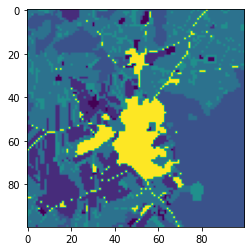

In [44]:
print(np.bincount(class_labels.flatten()))
plt.imshow(class_labels)

## load pre-processed data

In [45]:
print(input_list)

def inputs_to_npy(input_list):
    arr = []
    for fp in input_list:
        import rasterio
        with rasterio.open(fp) as src:
            a = src.read()
        arr.append(a)
    arr = np.stack(arr, axis=-1)
    return arr

inputs = inputs_to_npy(input_list)[:, 75:175, -150:-50, :]
inputs.shape, inputs.dtype

['/content/gdrive/MyDrive/B02.tif', '/content/gdrive/MyDrive/B03.tif', '/content/gdrive/MyDrive/B04.tif', '/content/gdrive/MyDrive/B08.tif', '/content/gdrive/MyDrive/B11.tif', '/content/gdrive/MyDrive/B12.tif']


((72, 100, 100, 6), dtype('uint8'))

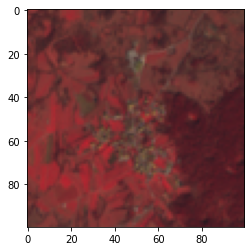

In [46]:
plt.imshow(inputs[32, :, :, [3,2,1]].swapaxes(0,1).swapaxes(1,2)*2)

## build tempcnn and fit

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### prepare labels

In [48]:
y = class_labels.flatten()

# encoding of labels
classes = list(set(list(y)))
n_classes = len(classes)
le = LabelEncoder()
le.fit(classes)
y = le.transform(y)

# one-hot encoding of labels
y = to_categorical(y, len(list(set(list(y)))))[:10000]
y.shape

(10000, 6)

### prepare EO data

In [49]:
shp = inputs.shape
X = inputs.reshape(shp[0], shp[1]*shp[2], shp[3]).swapaxes(0,1)[:10000]
X.shape

(10000, 72, 6)

### split into train and test set

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=np.argmax(y, axis=1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 72, 6), (2500, 72, 6), (7500, 6), (2500, 6))

### Build model with tf.keras

In [51]:
'''
Author: C. Pelettier; github.com/charlotte-pel/temporalCNN

This code is licensed under the
GNU General Public License v3.0
Permissions of this strong copyleft license are conditioned on making available complete source code of licensed works and modifications, which include larger works using a licensed work, under the same license. Copyright and license notices must be preserved. Contributors provide an express grant of patent rights.
'''

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Lambda, SpatialDropout1D, Concatenate
from tensorflow.keras.layers import Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D


#-----------------------------------------------------------------------
#---------------------- Modules
#-----------------------------------------------------------------------

#-----------------------------------------------------------------------		
def conv_bn(X, **conv_params):	
	nbunits = conv_params["nbunits"];
	kernel_size = conv_params["kernel_size"];

	strides = conv_params.setdefault("strides", 1)
	padding = conv_params.setdefault("padding", "same")
	kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-6))
	kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")

	Z = Conv1D(nbunits, kernel_size=kernel_size, 
			strides = strides, padding=padding,
			kernel_initializer=kernel_initializer,
			kernel_regularizer=kernel_regularizer)(X)

	return BatchNormalization(axis=-1)(Z) #-- CHANNEL_AXIS (-1)

#-----------------------------------------------------------------------		
def conv_bn_relu(X, **conv_params):
	Znorm = conv_bn(X, **conv_params)
	return Activation('relu')(Znorm)
	
#-----------------------------------------------------------------------		
def conv_bn_relu_drop(X, **conv_params):	
	dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
	A = conv_bn_relu(X, **conv_params)
	return Dropout(dropout_rate)(A)

#-----------------------------------------------------------------------		
def conv_bn_relu_spadrop(X, **conv_params):	
	dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
	A = conv_bn_relu(X, **conv_params)
	return SpatialDropout1D(dropout_rate)(A)

#-----------------------------------------------------------------------		
def conv2d_bn(X, **conv_params):	
	nbunits = conv_params["nbunits"];
	kernel_size = conv_params["kernel_size"];

	strides = conv_params.setdefault("strides", 1)
	padding = conv_params.setdefault("padding", "same")
	kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-6))
	kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")

	Z = Conv2D(nbunits, kernel_size=kernel_size, 
			strides = strides, padding=padding,
			kernel_initializer=kernel_initializer,
			kernel_regularizer=kernel_regularizer)(X)

	return BatchNormalization(axis=-1)(Z) #-- CHANNEL_AXIS (-1)

#-----------------------------------------------------------------------		
def conv2d_bn_relu(X, **conv_params):
	Znorm = conv2d_bn(X, **conv_params)
	return Activation('relu')(Znorm)
	
#-----------------------------------------------------------------------		
def conv2d_bn_relu_drop(X, **conv_params):	
	dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
	A = conv2d_bn_relu(X, **conv_params)
	return Dropout(dropout_rate)(A)

#-----------------------------------------------------------------------		
def conv2d_bn_relu_spadrop(X, **conv_params):	
	dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
	A = conv2d_bn_relu(X, **conv_params)
	return SpatialDropout1D(dropout_rate)(A)

	
#-----------------------------------------------------------------------		
def relu_drop(X, **conv_params):	
	dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
	A = Activation('relu')(X)
	return Dropout(dropout_rate)(A)

#-----------------------------------------------------------------------		
def fc_bn(X, **fc_params):
	nbunits = fc_params["nbunits"];
	
	kernel_regularizer = fc_params.setdefault("kernel_regularizer", l2(1.e-6))
	kernel_initializer = fc_params.setdefault("kernel_initializer", "he_normal")
		
	Z = Dense(nbunits, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(X)
	return BatchNormalization(axis=-1)(Z) #-- CHANNEL_AXIS (-1)
	
#-----------------------------------------------------------------------		
def fc_bn_relu(X, **fc_params):	
	Znorm = fc_bn(X, **fc_params)
	return Activation('relu')(Znorm)

#-----------------------------------------------------------------------		
def fc_bn_relu_drop(X, **fc_params):
	dropout_rate = fc_params.setdefault("dropout_rate", 0.5)
	A = fc_bn_relu(X, **fc_params)
	return Dropout(dropout_rate)(A)

#-----------------------------------------------------------------------		
def softmax(X, nbclasses, **params):
	kernel_regularizer = params.setdefault("kernel_regularizer", l2(1.e-6))
	kernel_initializer = params.setdefault("kernel_initializer", "glorot_uniform")
	return Dense(nbclasses, activation='softmax', 
			kernel_initializer=kernel_initializer,
			kernel_regularizer=kernel_regularizer)(X)


In [52]:
# from tempcnn import *

#-----------------------------------------------------------------------		
def Archi_3CONV64_1FC256(X, nbclasses):

    #-- get the input sizes
    m, L, depth = X.shape
    input_shape = (L,depth)

    #-- parameters of the architecture
    l2_rate = 1.e-6
    dropout_rate = 0.5
    nb_conv = 3
    nb_fc= 1
    nbunits_conv = 64 #-- will be double
    nbunits_fc = 256 #-- will be double

    # Define the input placeholder.
    X_input = Input(input_shape)
      
    #-- nb_conv CONV layers
    X = X_input
    for add in range(nb_conv):
        X = conv_bn_relu_drop(X, nbunits=nbunits_conv, kernel_size=5, kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
    #-- Flatten + 	1 FC layers
    X = Flatten()(X)
    for add in range(nb_fc):	
        X = fc_bn_relu_drop(X, nbunits=nbunits_fc, kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
      
    #-- SOFTMAX layer
    out = softmax(X, nbclasses, kernel_regularizer=l2(l2_rate))
      
    # Create model.
    return Model(inputs = X_input, outputs = out, name='Archi_3CONV64_1FC256')	

### Train TempCNN model

In [53]:
# training parameters
lr = 0.001
n_epochs = 10

In [54]:
model = Archi_3CONV64_1FC256(X, nbclasses=n_classes)
model.compile(optimizer=optimizers.Adam(lr), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_split=0.25)

Epoch 1/10
176/176 [==============================] - 11s 55ms/step - loss: 1.6157 - accuracy: 0.4445 - val_loss: 0.8396 - val_accuracy: 0.6885
Epoch 2/10
176/176 [==============================] - 10s 55ms/step - loss: 0.9781 - accuracy: 0.6499 - val_loss: 0.7307 - val_accuracy: 0.7232
Epoch 3/10
176/176 [==============================] - 9s 52ms/step - loss: 0.8672 - accuracy: 0.6866 - val_loss: 0.7037 - val_accuracy: 0.7328
Epoch 4/10
176/176 [==============================] - 9s 53ms/step - loss: 0.8185 - accuracy: 0.6986 - val_loss: 0.6647 - val_accuracy: 0.7509
Epoch 5/10
176/176 [==============================] - 9s 53ms/step - loss: 0.8014 - accuracy: 0.6969 - val_loss: 0.6546 - val_accuracy: 0.7483
Epoch 6/10
176/176 [==============================] - 9s 53ms/step - loss: 0.7813 - accuracy: 0.7167 - val_loss: 0.6406 - val_accuracy: 0.7493
Epoch 7/10
176/176 [==============================] - 9s 54ms/step - loss: 0.7303 - accuracy: 0.7197 - val_loss: 0.6363 - val_accuracy: 0.75

### Evaluate model on test set

In [55]:
proba = model.predict(X_test)

y_test_original = le.inverse_transform(np.argmax(y_test, axis=-1))
pred_original = le.inverse_transform(np.argmax(proba, axis=-1))

cm = confusion_matrix(y_test_original, pred_original)
print(cm)

[[  4   0   1  22   2  11]
 [  0 248   0 101   1  11]
 [  0   0 537  49  46   6]
 [  0  41  17 912  18  24]
 [  1   2  11  99  70   0]
 [  0  17   3  53   3 190]]


## predict map

In [56]:
shp = inputs.shape
X_all = inputs.reshape(shp[0], shp[1]*shp[2], shp[3])
X_all = X_all.swapaxes(0,1)
X_all.shape

(10000, 72, 6)

In [57]:
%%time
proba = model.predict(X_all)

CPU times: user 4.67 s, sys: 225 ms, total: 4.89 s
Wall time: 2.8 s


In [58]:
pred_flat = le.inverse_transform(np.argmax(proba, axis=-1))
pred = pred_flat.reshape(shp[1], shp[2])
pred.shape

(100, 100)

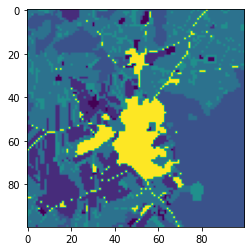

In [59]:
plt.imshow(class_labels)

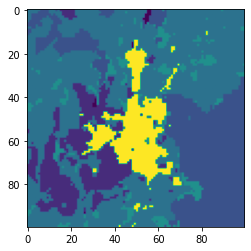

In [60]:
plt.imshow(pred)